# Introdução

O Modelo 1 consiste aplicar técnicas clássicas de ML para classificar a satisfação de clientes com a Base da Anatel, considerando o seguinte recote: 

- Dados de 2017 a 2020; 
- Remoção das Colunas E2, E4, E6 e E8, que representam respostas de satisfação condicionais; 
- Remoção das Colunas F2_1, F2_2, F2_3, F4_1, F4_2 e F4_3, que representam respostas condicionais em relação a serviços de manutenção e instalação; 
- Remoção das Colunas A2_1, A2_2, A2_3, A1_4, A3 e A4 que representam respostas condicionais a satisfação dos atendimentos telefonicos, via internet e presencial;
- Remoção das Colunas Q2, Q2_1, Q2_2 que representam a área de trabalho do entrevistado. 
- Remoção da Coluna Q3, que indica se o usuário é cliente da internet. No caso todas as linhas apresentam valores igual a 1. 
- Remoção da Q4 que pergunta de o respondentes é um dos principais usuários. No caso todas as linhas apresentam valores igual a 1. 
- Remoção da Coluna Q7a, que é respondida apenas caso o cliente se recusa a responder a idade.
- Remoção da Coluna IDTNS que é um indicador de pesquisa. 
- Remoção das Colunas G1, G2_1, G2_2, G2_3, que representam respostas condicionais em relação a concorrência do serviço na Região.
- Remoção da Coluna I1 que indica autorização para identificaçãod as respostas. 
- Remoção da Coluna COD_IBGE que indica uma codificação do IBGE.
- Remoção da Coluna PESO que indica um calculo UFxPrestadora;
- Remoção da Coluna Q1 que pergunta se o entrevistao tem interesse em participar da pesquisa. No caso todas as linhas tem mesmo valor. 
- Remoção da Coluna Q6 que indica se é PF ou PJ. No caso a base só abrange PF's;
- Remoção da Coluna H3 que indica uma codificação específica. (No Glossário não fala o que é o H3)
- Remoção da Coluna H2a que é respondida em caso de recusa da resposta H2.
- Remoção da Coluna I2 que indica autorização para identificação das repostas para operadora citada; 
- Remoção da Coluna Data, pois é considerado apenas o Ano. 
- Remoção da Coluna Tipo, pois indica o tipo do serviço pesquisado e no caso é Banda Larga. 
- Remoção da Coluna H0 que indica o Município, e no caso é considerado só o estado. 

# Objetivo

O objetivo da aplicação de ML para este caso é analisar o desempenho das técnicas, e assim extrair as features mais relevantes para satisfação. 

# Bibliotecas

In [1]:
#Básicas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import missingno as msno
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import locale
import time
from tensorflow import keras
import joblib
import shap
#Sklearn
## Funcionalidades
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn import preprocessing
## Técnicas


##Ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import matplotlib.ticker as mtick
from sklearn.neural_network import MLPClassifier
#from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score

#Keras
from tensorflow import keras
#Importar modelo Sequencuial
from keras.models import Sequential 

#utilizar Camadas Densas na Rede Neural - Ligação de um Neuronio com todos os outros
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')



C:\Users\Matheus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pt_BR.UTF-8'

# Subrotinas Aplicadas

In [2]:
def plot_roc_curve(fpr, tpr, legenda):
    plt.rcParams['axes.formatter.use_locale'] = True
    plt.plot(fpr, tpr, linewidth = 2, label = legenda)
    plt.gcf().set_size_inches(12, 6)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.rcParams["figure.dpi"] = 100
    plt.legend()
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")


def plot_dict_bar(dict):
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.xticks(range(len(dict)), list(dict.keys()), rotation=90)
    plt.show()


def NN_Model(taxa_aprendizagem  = 0.001, f_ativacao = "sigmoid", f_perda = "binary_crossentropy", 
    camadas_ocultas = 1, neuronios = 24, activation_camada = "relu"):
    classificador = Sequential() #classificador sequencial

    #CAMADA OCULTA
    classificador.add(Dense(units = 24, activation = activation_camada, kernel_initializer= 'random_uniform', input_dim = 24))
    ## Modificar - > 
    #segunda camada oculta
    for i in range(camadas_ocultas): 
        classificador.add(Dense(units = neuronios, activation = activation_camada, kernel_initializer= 'random_uniform'))


    #Kernel_initializer = Forma de inicializacao dos pesos, no caso foi utilizado randomico uniforme
    #input_dim = quantidade de entradas

    #CAMADA DE SAIDA
    classificador.add (Dense(units = 1, activation=f_ativacao))

    otimizador = keras.optimizers.Adam(learning_rate = taxa_aprendizagem, decay = 0.0001, clipvalue = 0.5)

    classificador.compile (optimizer= otimizador, loss = f_perda, metrics= ['accuracy'])

    return classificador

def NN_SciKeras_Model(hidden_layer_dim, activation_hidden_layer, meta):
    # note that meta is a special argument that will be
    # handed a dict containing input metadata
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]

    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_features_in_, input_shape=X_shape_[1:]))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.Dense(hidden_layer_dim))
    model.add(keras.layers.Activation(activation_hidden_layer))
    model.add(keras.layers.Dense(hidden_layer_dim))
    model.add(keras.layers.Activation(activation_hidden_layer))
    model.add(keras.layers.Dense(1))
    model.add(keras.layers.Activation("sigmoid"))
    return model


# Dados

Os dados foram tratados conforme os seguintes parâmetros:

- Remoção das Colunas conforme descrito na introdução; 
- A coluna J1, que indica a satisfação geral é a variável de saída, onde Satisfação >= 6 = Satisfeito, e Satisfação < 6 = Insatisfeito. 
- 1 é Sim, e 2 é Não;
- Variáveis categóricas como estados, operadoras, e etc, foram substiuidas por valores numéricos de 1 ao total de opções; 
- Linhas com celulas igual a 99 foram removidas da base. 

In [15]:
dados= pd.read_csv(r"C:\Users\Matheus\Desktop\Mestrado\Projeto\machine-learning-anatel-database\raw_data\Anatel.csv")

linhas= dados.index
colunas= dados.columns

Data_Filter = dados.copy()

Data_Filter = Data_Filter[ dados["ANO_BASE"] > 2016]


Data_Filter["ESTADO"] = Data_Filter["ESTADO"].astype('category').cat.codes
Data_Filter["OPERADORA"] = Data_Filter["OPERADORA"].astype('category').cat.codes
Data_Filter.drop("Q2", inplace= True, axis = 1)
Data_Filter.drop("Q2_1", inplace= True, axis = 1)
Data_Filter.drop("Q2_2", inplace= True, axis = 1)
Data_Filter.drop("Q3", inplace= True, axis = 1)
Data_Filter.drop("Q4", inplace= True, axis = 1)
Data_Filter.drop("Q7a", inplace= True, axis = 1)
Data_Filter.drop("A2_1", inplace= True, axis = 1)
Data_Filter.drop("A2_2", inplace= True, axis = 1)
Data_Filter.drop("A2_3", inplace= True, axis = 1)
Data_Filter.drop("A1_4", inplace= True, axis = 1)
Data_Filter.drop("A3", inplace= True, axis = 1)
Data_Filter.drop("A4", inplace= True, axis = 1)
Data_Filter.drop("IDTNS", inplace= True, axis = 1)
Data_Filter.drop("G1", inplace= True, axis = 1)
Data_Filter.drop("G2_1", inplace= True, axis = 1)
Data_Filter.drop("G2_2", inplace= True, axis = 1)
Data_Filter.drop("G2_3", inplace= True, axis = 1)
Data_Filter.drop("E2", inplace= True, axis = 1)
Data_Filter.drop("E4", inplace= True, axis = 1)
Data_Filter.drop("E6", inplace= True, axis = 1)
Data_Filter.drop("E8", inplace= True, axis = 1)
Data_Filter.drop("F2_1", inplace= True, axis = 1)
Data_Filter.drop("F2_2", inplace= True, axis = 1)
Data_Filter.drop("F2_3", inplace= True, axis = 1)
Data_Filter.drop("F4_1", inplace= True, axis = 1)
Data_Filter.drop("F4_2", inplace= True, axis = 1)
Data_Filter.drop("F4_3", inplace= True, axis = 1)
Data_Filter.drop("I1", inplace= True, axis = 1)
Data_Filter.drop("PESO", inplace= True, axis = 1)
Data_Filter.drop("Q1", inplace= True, axis = 1)
Data_Filter.drop("Q6", inplace= True, axis = 1)
Data_Filter.drop("H3", inplace= True, axis = 1)
Data_Filter.drop("COD_IBGE", inplace= True, axis = 1)
Data_Filter.drop("H2a", inplace= True, axis = 1)
Data_Filter.drop("I2", inplace= True, axis = 1)
Data_Filter.drop("TIPO", inplace= True, axis = 1)
Data_Filter.drop("DATA", inplace= True, axis = 1)
Data_Filter.drop("H0", inplace= True, axis = 1)





Data_Filter["A1_2"] = Data_Filter["A1_2"].replace(2,1)
Data_Filter["A1_3"] = Data_Filter["A1_3"].replace(3,1)
Data_Filter["A1_2"] = Data_Filter["A1_2"].fillna(2)
Data_Filter["A1_3"] = Data_Filter["A1_3"].fillna(2)
Data_Filter["A1_1"] = Data_Filter["A1_1"].fillna(2)



Data_Filter = Data_Filter[Data_Filter.J1 != 99]
Data_Filter = Data_Filter[Data_Filter.B1_1 != 99]
Data_Filter = Data_Filter[Data_Filter.B1_2 != 99]
Data_Filter = Data_Filter[Data_Filter.C1_1 != 99]
Data_Filter = Data_Filter[Data_Filter.C1_2 != 99]
Data_Filter = Data_Filter[Data_Filter.C1_3 != 99]
Data_Filter = Data_Filter[Data_Filter.D1_1 != 99]
Data_Filter = Data_Filter[Data_Filter.D1_2 != 99]
Data_Filter = Data_Filter[Data_Filter.H1 != 99]
Data_Filter = Data_Filter[Data_Filter.Q7 != 999999] ##Remove pessoas que não respondem a idade
Data_Filter = Data_Filter[Data_Filter.H1 != 999999] ##Remove pessoas que não respondem quantas pessoas moram na residência
Data_Filter = Data_Filter[Data_Filter.H1 != 99999] ##Remove pessoas que não respondem quantas pessoas moram na residência 
Data_Filter = Data_Filter[Data_Filter.H2 != 999999] ##Remove pessoas que não respondem a renda
Data_Filter = Data_Filter[Data_Filter.H2 != 999998] ##Remove pessoas que não respondem a renda
Data_Filter = Data_Filter[Data_Filter.H2 != 999997] ##Remove pessoas que não respondem a renda

Data_Filter.loc[Data_Filter.J1 >= 8, "J1"] = "SATISFEITO"
Data_Filter.loc[Data_Filter.J1 != "SATISFEITO", "J1"] = "INSATISFEITO"

Data_Filter["J1"] = Data_Filter["J1"].replace("SATISFEITO",1)
Data_Filter["J1"] = Data_Filter["J1"].replace("INSATISFEITO",0)


#Data_Filter.info()

Dados_Y = Data_Filter["J1"].copy()
Dados_X = Data_Filter.copy()
Dados_X.drop("J1", inplace= True, axis = 1)

#X_train, X_test, y_train, y_test = train_test_split(Dados_X, Dados_Y, test_size=0.3,random_state=109) # 70% training and 30% tes

X_train, X_test, y_train, y_test = train_test_split(Dados_X, Dados_Y, test_size=0.5,random_state=109)


Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.


## Representação dos Dados Utilizados

### Células Vazias

<AxesSubplot:>

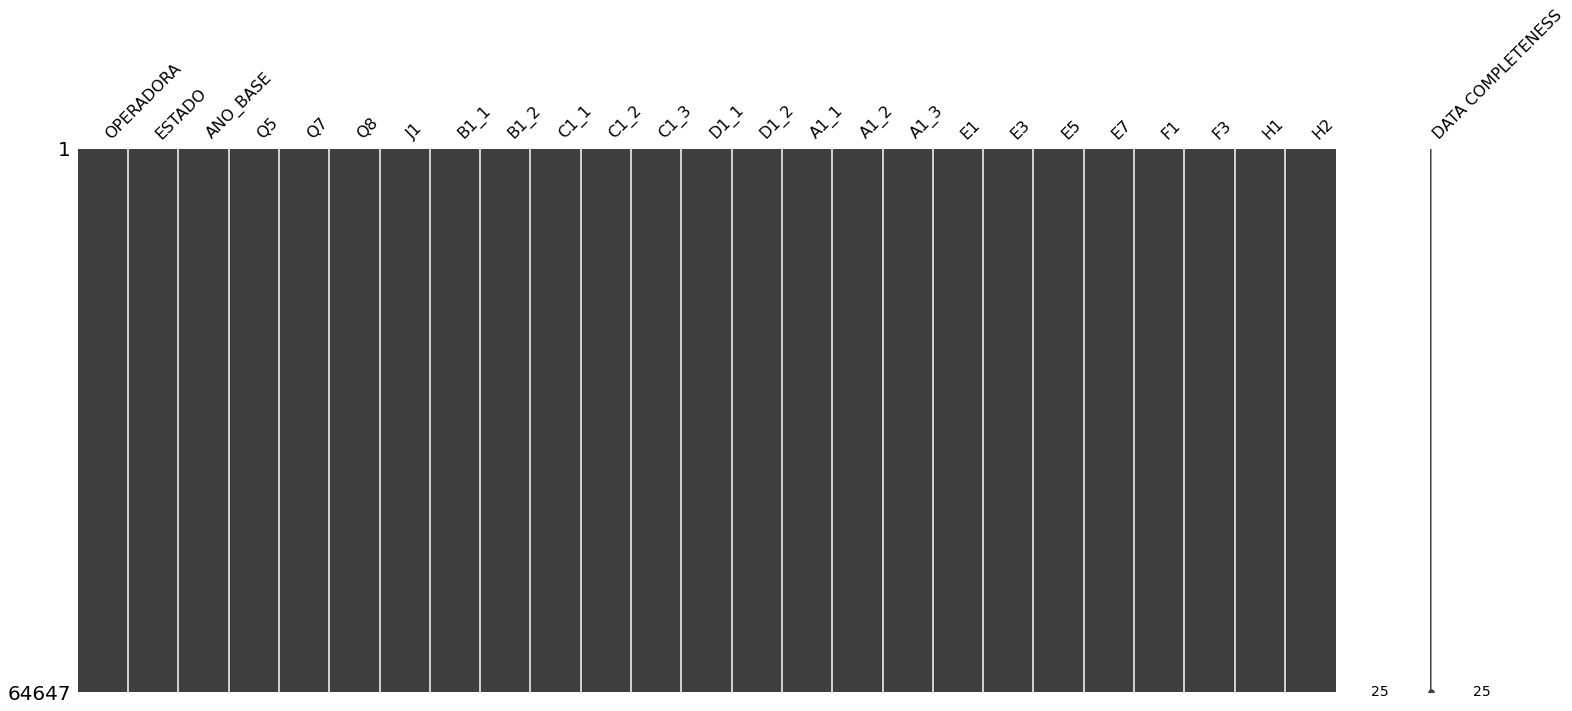

In [4]:
msno.matrix(Data_Filter, labels=True)

### Conteúdo das Células

In [5]:
Info = Data_Filter.info()

Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64647 entries, 1 to 91934
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OPERADORA  64647 non-null  int8   
 1   ESTADO     64647 non-null  int8   
 2   ANO_BASE   64647 non-null  int64  
 3   Q5         64647 non-null  int64  
 4   Q7         64647 non-null  int64  
 5   Q8         64647 non-null  int64  
 6   J1         64647 non-null  int64  
 7   B1_1       64647 non-null  int64  
 8   B1_2       64647 non-null  int64  
 9   C1_1       64647 non-null  int64  
 10  C1_2       64647 non-null  int64  
 11  C1_3       64647 non-null  int64  
 12  D1_1       64647 non-null  int64  
 13  D1_2       64647 non-null  int64  
 14  A1_1       64647 non-null  float64
 15  A1_2       64647 non-null  float64
 16  A1_3       64647 non-null  float64
 17  E1         64647 non-null  int64  
 18  E3         64647 non-null  int64  
 19  E5         64647 non-null  float64
 20  E7    

# Notes

- scale Normal - standarstcale -> Só para as colunas H1 e H2. 
- sklearn.preprocessing.RobustScaler -> Utilizar Esse para H1 e H2. Para todas as técnicas. 
- Programar para relatar a precisao e acuracia por Classe e Categoria
- Junto com com o Boxplot e Validacao Cruzada. 


In [6]:
Describe = Data_Filter.describe()

Describe

,OPERADORA,ESTADO,ANO_BASE,Q5,Q7,Q8,J1,B1_1,B1_2,C1_1,...,A1_2,A1_3,E1,E3,E5,E7,F1,F3,H1,H2
count,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,...,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000,64647.000000
mean,8.139032,13.008477,2018.520612,1.182128,41.771080,1.508670,0.403066,6.835244,6.386097,6.735285,...,1.583105,1.862345,1.526258,1.594923,1.726499,1.333519,1.851671,1.523644,1.936888,5631.666589
std,3.249403,7.518184,1.179470,0.385953,13.586814,0.499929,0.490518,2.655812,2.906586,2.792815,...,0.493049,0.344540,0.499314,0.490911,0.445759,0.471474,0.355428,0.499445,0.950224,9229.153857
min,0.000000,0.000000,2017.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,170.000000
25%,7.000000,7.000000,2017.000000,1.000000,31.000000,1.000000,0.000000,5.000000,5.000000,5.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2000.000000
50%,8.000000,13.000000,2019.000000,1.000000,40.000000,2.000000,0.000000,7.000000,7.000000,7.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3500.000000
75%,10.000000,19.000000,2020.000000,1.000000,51.000000,2.000000,1.000000,9.000000,8.000000,9.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6000.000000
max,13.000000,26.000000,2020.000000,2.000000,97.000000,2.000000,1.000000,10.000000,10.000000,10.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,20.000000,800000.000000


# Grid Search

In [5]:
parameter_space_NN = {
    "hidden_layer_dim": [24, 48, 96],
    "loss": ["binary_crossentropy"],
    "optimizer": ["adam", "sgd"],
    "optimizer__learning_rate": [0.0001, 0.001, 0.1],
    "activation_hidden_layer" : ["sigmoid", "relu"]
}

param_space_ada_boost = {'n_estimators':[1, 5, 10],
                        'learning_rate':[0.1, 1, 2]}
param_space_gra_boost = {
              "loss":["log_loss","exponential"],
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,1,0.5], 
              'max_depth': [3,4,5],
              'min_samples_leaf': [4,5,6],
              'subsample': [0.6,0.7,0.8],
              'n_estimators': [5,10,15,20],
              }

              
param_space_histogram_boost = {'max_iter': [1000,1200,1500],
                            'learning_rate': [0.1],
                            'max_depth' : [25, 50, 75],
                            'l2_regularization': [1.5],}


param_space_logistic_regression = {'penalty': ['l2', 'none'],
                                    'tol': [1e-6, 1e-2],
                                    'fit_intercept': [True, False],
                                    'max_iter': [10000]}

param_space_random_forest = {   'n_estimators': [200, 400],
                                'max_depth' : [6,12,24],
                                'min_samples_split': [2,4],
                                'min_samples_leaf': [2,4],
                                'criterion' :['gini', 'entropy']}
                                
param_space_decision_tree = {   'splitter': ["best", "random"],
                                'criterion' :['gini', 'entropy'],
                                'max_depth': [6,12,16,24],
                                'min_samples_leaf': [2,4],
                                'min_samples_split': [2,4]}

param_space_knn = {'n_neighbors': [1, 2, 4, 6, 7, 10],
                    'weights': ["uniform", "distance"]}

#param_space_svm = {  'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'],'probability': [True]}

param_space_svm = { 'gamma': [1,0.1,0.01,0.001],
                    'kernel': ['rbf', 'sigmoid'],
                    'C': [1, 10, 100, 1000] }


## Voltar o C; 
## Tirar o Poly e testar com sigmoid, 

#Setar Learning_Rate_Init

Param_Grid = { "RF": param_space_random_forest, "KNN": param_space_knn, "Logistic Regression": param_space_logistic_regression, 
 "Decision Tree": param_space_decision_tree, "SVM": param_space_svm, "Histogram Gradient Boosting":param_space_histogram_boost,
 "Gradient Boosting":param_space_gra_boost, "Ada Boost": param_space_ada_boost, "Neural Network": parameter_space_NN}

Rand_Forest_Class_GRID = RandomForestClassifier()
Knn_Class_GRID = KNeighborsClassifier()
logisticRegr_GRID = LogisticRegression()
Decision_Tree_GRID = tree.DecisionTreeClassifier()
SVM_Class_GRID = SVC() # rbf  Kernel
Hist_Grad_Boost_Class_GRID = HistGradientBoostingClassifier()
Grad_Boost_Class_GRID = GradientBoostingClassifier()
Ada_Boost_Class_GRID = AdaBoostClassifier()

NeuralNetwork_GRID =KerasClassifier(
    NN_SciKeras_Model,
    loss="binary_crossentropy",optimizer="adam",
    hidden_layer_dim=48, epochs=50, activation_hidden_layer = "sigmoid", verbose=0
)


classifiers_GRID_Input = dict()

classifiers_GRID_Input = {"RF": Rand_Forest_Class_GRID, "KNN": Knn_Class_GRID, "Logistic Regression": logisticRegr_GRID,
 "Decision Tree": Decision_Tree_GRID, "SVM": SVM_Class_GRID, "Histogram Gradient Boosting":Hist_Grad_Boost_Class_GRID,
 "Gradient Boosting":Grad_Boost_Class_GRID, "Ada Boost": Ada_Boost_Class_GRID, "Neural Network": NeuralNetwork_GRID}

classifiers_GRID_Output = dict()


classifiers_GRID_Result = dict()

classifiers_GRID_Result = {"RF": Rand_Forest_Class_GRID, "KNN": Knn_Class_GRID, "Logistic Regression": logisticRegr_GRID,
 "Decision Tree": Decision_Tree_GRID, "SVM": SVM_Class_GRID, "Histogram Gradient Boosting":Hist_Grad_Boost_Class_GRID,
 "Gradient Boosting":Grad_Boost_Class_GRID, "Ada Boost": Ada_Boost_Class_GRID, "Neural Network": NeuralNetwork_GRID}

time_GRID = dict()
estimators_GRID = dict()
params_GRID = dict()
 


 Iniciando Grid Search:  Histogram Gradient Boosting 

Histogram Gradient Boosting Concluido em: 58.45  segundos 

Progresso:  11 % 


 Iniciando Grid Search:  Gradient Boosting 

Gradient Boosting Concluido em: 1962.68  segundos 

Progresso:  22 % 



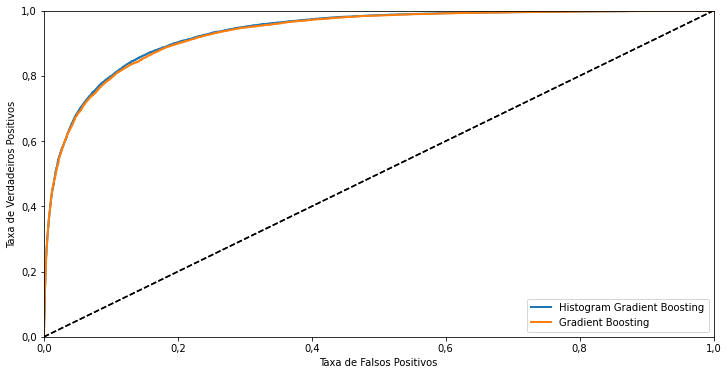

In [7]:
progress = 0
total = len(Param_Grid)
desempenho_ml_GRID = pd.DataFrame(columns=['ML','Acc','Precision','Recall', 'F1', 'AUC-Score', 'Tempo'])
#Param_Grid = { "SVM": param_space_svm}
#Param_Grid = {"Neural Network": parameter_space_NN}
Param_Grid = {"Histogram Gradient Boosting":param_space_histogram_boost, "Gradient Boosting":param_space_gra_boost}
for number, i in enumerate(Param_Grid):
    print("\n Iniciando Grid Search: ", i,"\n")
    start = time.time()
    classifiers_GRID_Output[i] = GridSearchCV(estimator=classifiers_GRID_Input[i], param_grid=Param_Grid[i], cv= 5) 
    classifiers_GRID_Output[i].fit(X_train, y_train)

    classifiers_GRID_Result[i].set_params(**classifiers_GRID_Output[i].best_params_)
    if i == "SVM":
        print("oi")
        classifiers_GRID_Result[i].set_params(**{'probability': True})
    
    classifiers_GRID_Result[i].fit(X_train, y_train)
    y_pred = classifiers_GRID_Result[i].predict(X_test)
    end = time.time()
    time_GRID[i] = end - start
    acc = metrics.accuracy_score(y_test, y_pred)
    y_pred_prob = classifiers_GRID_Result[i].predict_proba(X_test)
    y_pred_prob = y_pred_prob[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    pr = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred)
    fpr, tpr, threshold = roc_curve(y_test,y_pred_prob)
    plot_roc_curve(fpr,tpr,  i)
    auc = roc_auc_score(y_test,y_pred_prob)
    desempenho_ml_GRID.loc[number] = pd.Series({'ML': i, 'Acc': acc, 'Precision': pr, 'Recall': rec, 'F1': F1, 'AUC-Score': auc, 'Tempo': time_GRID[i]})
    
    params_GRID[i] = classifiers_GRID_Output[i].best_params_
    print(i,"Concluido em:", "%.2f" % time_GRID[i]," segundos \n")
    progress=progress+1
    aux = progress/total
    aux = aux*100
    print("Progresso: ","%.0f" % aux,"% \n")



### Observações
- O Resultado acima mostra apenas a rede neural, pois foi rodado apenas ele para economizar tempo. Os demais já tinham sido treinados e salvos. 

In [9]:
desempenho_ml_GRID

,ML,Acc,Precision,Recall,F1,AUC-Score,Tempo
0,RF,0.859578,0.833477,0.814218,0.823735,0.934399,2099.720637
1,KNN,0.813173,0.756818,0.790342,0.773217,0.890843,255.730355
2,Logistic Regression,0.854473,0.814275,0.827652,0.820909,0.927743,40.61433
3,Decision Tree,0.852927,0.820521,0.812836,0.81666,0.927025,41.411716
4,SVM,0.842748,0.805524,0.803854,0.804688,0.918368,30697.742096
5,Histogram Gradient Boosting,0.859578,0.8299,0.819515,0.824675,0.934381,69.087145
6,Gradient Boosting,0.858495,0.837271,0.805389,0.821021,0.932605,2243.087246
7,Ada Boost,0.850235,0.810438,0.820206,0.815292,0.925376,7.339362
8,Neural Network,0.839407,0.878978,0.697528,0.777811,0.925859,8109.281339


## Saving Models

### Sklearn

In [10]:
files = dict()

for i in classifiers_GRID_Result:
    if i != "Neural Network":
        filenameaux = i + ".sav"
        filename = filenameaux.replace(" ","")
        joblib.dump(classifiers_GRID_Result[i], filename)




### SciKeras

In [11]:
filename = "NeuralNewtorkSciKeras"
classifiers_GRID_Result["Neural Network"].model_.save(filename)

INFO:tensorflow:Assets written to: NeuralNewtorkSciKeras\assets


## Especific Models

In [8]:
joblib.dump(classifiers_GRID_Result["Histogram Gradient Boosting"], "HistogramGradientBoosting.sav")
joblib.dump(classifiers_GRID_Result["Gradient Boosting"], "GradientBoosting.sav")

['GradientBoosting.sav']

# Load Models

In [6]:
Models_Loaded_GridSearch = dict()

for i in classifiers_GRID_Result:
    if i == "Neural Network":
        filename = "NeuralNewtorkSciKeras"
        aux = keras.models.load_model(filename)
        Models_Loaded_GridSearch[i] = KerasClassifier(aux)
        Models_Loaded_GridSearch[i].initialize(X_train, y_train)
    else:
        filenameaux = i + ".sav"
        filename = filenameaux.replace(" ","")
        Models_Loaded_GridSearch[i] = joblib.load(filename)



Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator KNeighborsClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.1.2. This might lead to break

In [6]:
print(Models_Loaded_GridSearch)

{'RF': RandomForestClassifier(max_depth=12, max_features='auto', min_samples_leaf=4,
                       min_samples_split=4, n_estimators=400), 'KNN': KNeighborsClassifier(n_neighbors=10, weights='distance'), 'Logistic Regression': LogisticRegression(fit_intercept=False, max_iter=10000, tol=1e-06), 'Decision Tree': DecisionTreeClassifier(max_depth=6, min_samples_leaf=2), 'SVM': SVC(C=10, gamma=0.001, probability=True), 'Histogram Gradient Boosting': HistGradientBoostingClassifier(l2_regularization=1.5, max_depth=25,
                               max_iter=1200), 'Gradient Boosting': GradientBoostingClassifier(loss='exponential', max_depth=5, max_features='sqrt',
                           min_samples_leaf=5, n_estimators=20, subsample=0.8), 'Ada Boost': AdaBoostClassifier(learning_rate=1, n_estimators=10), 'Neural Network': KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x000001FEA532F040>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop

# Run Loaded Models

1011/1011 [==============================] - 1s 935us/step


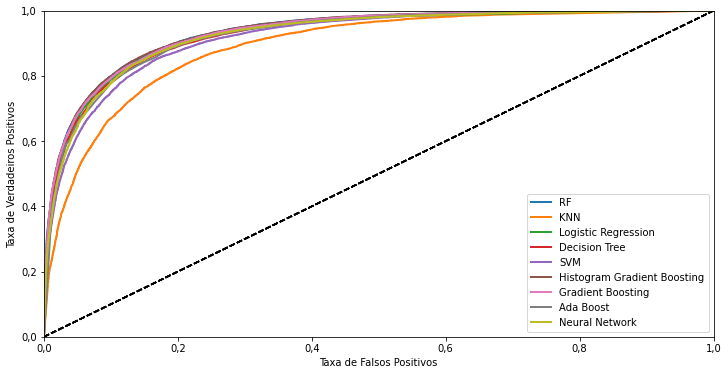

In [7]:
desempenho_ml_1 = pd.DataFrame(columns=['ML','Acc','Precision','Recall', 'F1', 'AUC-Score'])
y_pred_prob =[]
y_pred = []
for number, i in enumerate(Models_Loaded_GridSearch):   
    y_pred = Models_Loaded_GridSearch[i].predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    y_pred_prob = Models_Loaded_GridSearch[i].predict_proba(X_test)
    y_pred_prob = y_pred_prob[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    pr = precision_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred)
    fpr, tpr, threshold = roc_curve(y_test,y_pred_prob)
    plot_roc_curve(fpr,tpr,  i)
    auc = roc_auc_score(y_test,y_pred_prob)
    desempenho_ml_1.loc[number] = pd.Series({'ML': i, 'Acc': acc, 'Precision': pr, 'Recall': rec, 'F1': F1, 'AUC-Score': auc})
    y_pred_prob =[]
    y_pred = []
    

In [8]:
desempenho_ml_1

,ML,Acc,Precision,Recall,F1,AUC-Score
0,RF,0.859578,0.833477,0.814218,0.823735,0.934399
1,KNN,0.813173,0.756818,0.790342,0.773217,0.890843
2,Logistic Regression,0.854473,0.814275,0.827652,0.820909,0.927743
3,Decision Tree,0.852927,0.820521,0.812836,0.81666,0.927025
4,SVM,0.842748,0.805524,0.803854,0.804688,0.918368
5,Histogram Gradient Boosting,0.859609,0.829759,0.819822,0.824761,0.934518
6,Gradient Boosting,0.857629,0.836261,0.804161,0.819897,0.932631
7,Ada Boost,0.850235,0.810438,0.820206,0.815292,0.925376
8,Neural Network,0.839407,0.878978,0.697528,0.777811,0.925859


# Cross Validation

INFO:tensorflow:Assets written to: C:\Users\Matheus\AppData\Local\Temp\tmp6qw1tgws\assets
203/203 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Matheus\AppData\Local\Temp\tmp4vpgeptd\assets
203/203 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Matheus\AppData\Local\Temp\tmp3hk2uav5\assets
203/203 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Matheus\AppData\Local\Temp\tmp1163911s\assets
203/203 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Matheus\AppData\Local\Temp\tmpg3dlml4d\assets
203/203 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Matheus\AppData\Local\Temp\tmpkzpcho08\assets
203/203 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Matheus\AppData\Local\Temp\tmpyf87qlqu\assets
203/203 [==============================]

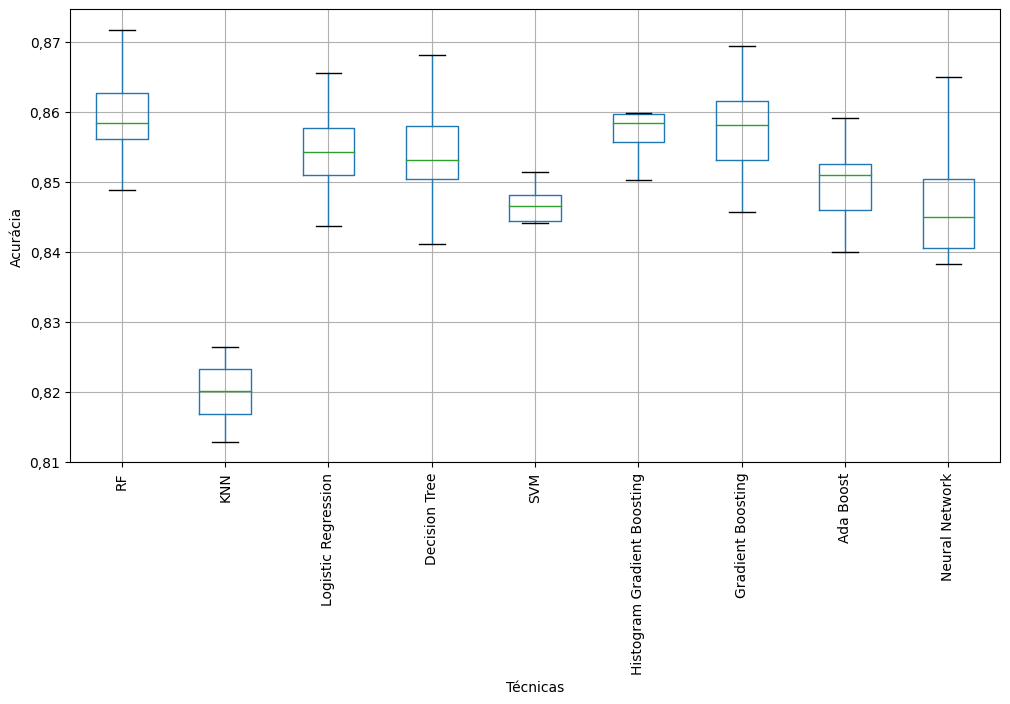

In [15]:
def plot_box_plot(dataframe):
    dataframe.boxplot(showfliers=False)
    plt.ylabel("Acurácia")
    plt.xlabel("Técnicas")
    plt.xticks(rotation = 90)
    plt.gcf().set_size_inches(12, 6)
    plt.rcParams["figure.dpi"] = 100


cv_dataframe = pd.DataFrame()
desempenho_cross_val = pd.DataFrame(columns=['ML','Media','Variancia','Desvio'])

for number, i in enumerate(Models_Loaded_GridSearch):
    scores = cross_val_score(Models_Loaded_GridSearch[i], Dados_X, Dados_Y, cv=10, scoring = 'accuracy')
    desempenho_cross_val.loc[number +1] = pd.Series({'ML': i, 'Media':  scores.mean(), 'Variancia': scores.var() , 'Desvio': scores.std()}) 
    cv_dataframe[i] = scores.tolist()
desempenho_cross_val.head()
plot_box_plot(cv_dataframe)


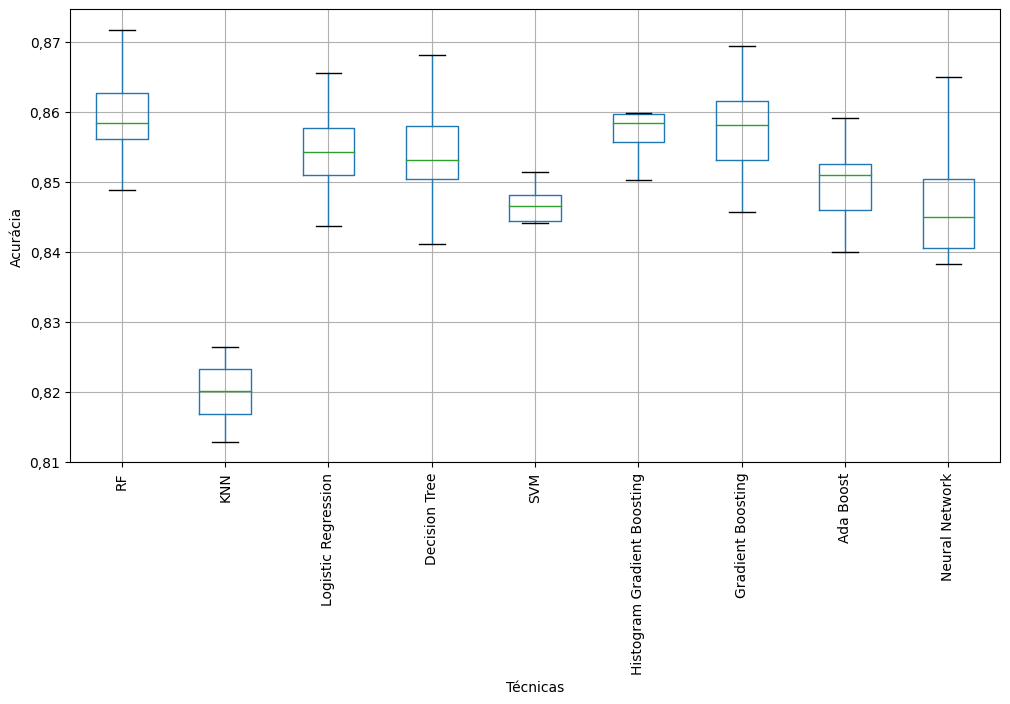

In [16]:
def plot_box_plot(dataframe):
    dataframe.boxplot(showfliers=False)
    plt.ylabel("Acurácia")
    plt.xlabel("Técnicas")
    plt.xticks(rotation = 90)
    plt.gcf().set_size_inches(12, 6)
    plt.rcParams["figure.dpi"] = 100

plot_box_plot(cv_dataframe)

## Best Params

In [10]:
for i in classifiers_GRID_Output:
    print(i, ":", classifiers_GRID_Output[i].best_params_)

RF : {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
KNN : {'n_neighbors': 10, 'weights': 'uniform'}
Logistic Regression : {'fit_intercept': False, 'max_iter': 10000, 'penalty': 'l2', 'tol': 1e-06}
Decision Tree : {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
SVM : {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Histogram Gradient Boosting : {'l2_regularization': 1.5, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 1200}
Gradient Boosting : {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 20, 'subsample': 0.7}
Ada Boost : {'learning_rate': 1, 'n_estimators': 10}
Neural Network : {'activation_camada': 'sigmoid', 'camadas_ocultas': 2, 'f_ativacao': 'sigmoid', 'f_perda': 'binary_crossentropy', 'neuronios': 48, 'taxa_aprendizagem': 0.0001}


# Feature Importances
## Random Forest

C:\Users\Matheus\AppData\Local\Temp\ipykernel_10816\2909010372.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


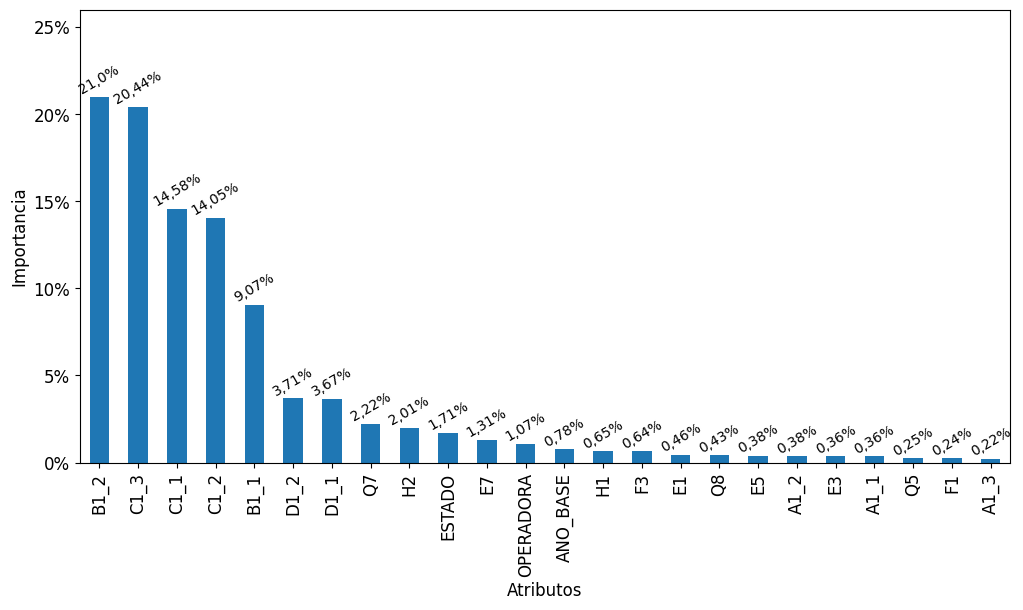

In [17]:
importances  = Models_Loaded_GridSearch["RF"].feature_importances_
forest_importances = pd.Series(importances, index=X_test.columns)
forest_importances_sorted = forest_importances.sort_values(ascending=False)

labels = list()
for i in forest_importances_sorted:
    i_str = str(round(i*100,2)) + "%"
    i_str = i_str.replace(".", ",")
    labels.append(i_str)


fig, ax = plt.subplots()
forest_importances_sorted.plot.bar()
ax.bar_label(ax.containers[0], labels=labels, rotation = 30)
plt.rcParams['axes.formatter.use_locale'] = True
ax.set_ylabel("Importancia", fontsize = 12)
ax.set_xlabel("Atributos", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim([0, 0.26])
plt.rcParams["figure.dpi"] = 100
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.gcf().set_size_inches(12, 6)

## Decision Tree

C:\Users\Matheus\AppData\Local\Temp\ipykernel_10816\3452593319.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


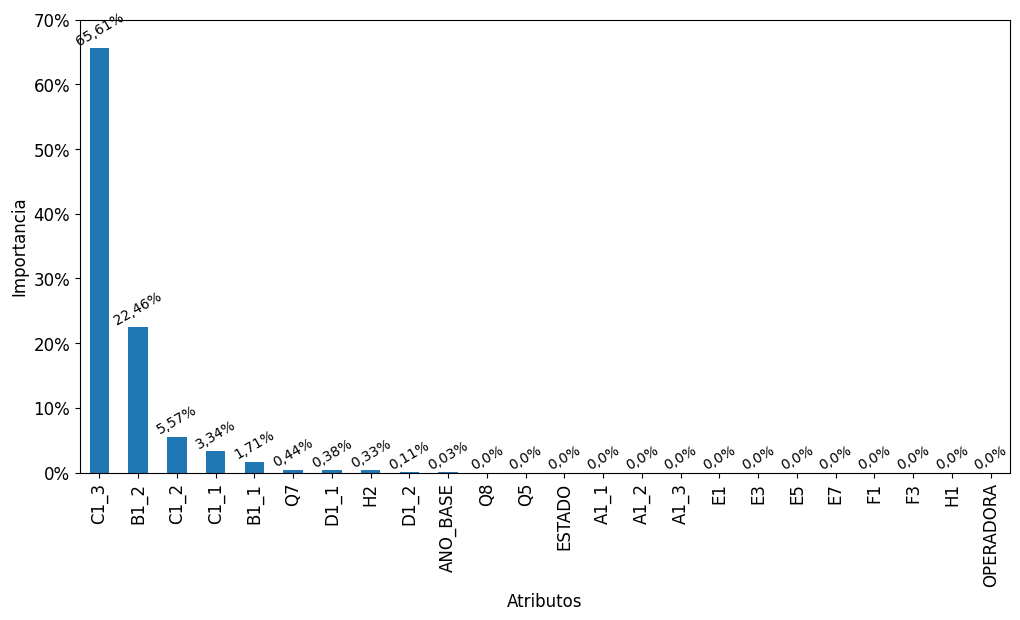

In [18]:
importances  = Models_Loaded_GridSearch["Decision Tree"].feature_importances_
forest_importances = pd.Series(importances, index=X_test.columns)
forest_importances_sorted = forest_importances.sort_values(ascending=False)

labels = list()
for i in forest_importances_sorted:
    i_str = str(round(i*100,2)) + "%"
    i_str = i_str.replace(".", ",")
    labels.append(i_str)


fig, ax = plt.subplots()
forest_importances_sorted.plot.bar()
ax.bar_label(ax.containers[0], labels=labels, rotation = 30)
plt.rcParams['axes.formatter.use_locale'] = True
ax.set_ylabel("Importancia", fontsize = 12)
ax.set_xlabel("Atributos", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim([0, 0.70])
plt.rcParams["figure.dpi"] = 100
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.gcf().set_size_inches(12, 6)

## Gradient Boosting

C:\Users\Matheus\AppData\Local\Temp\ipykernel_10816\3384879188.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


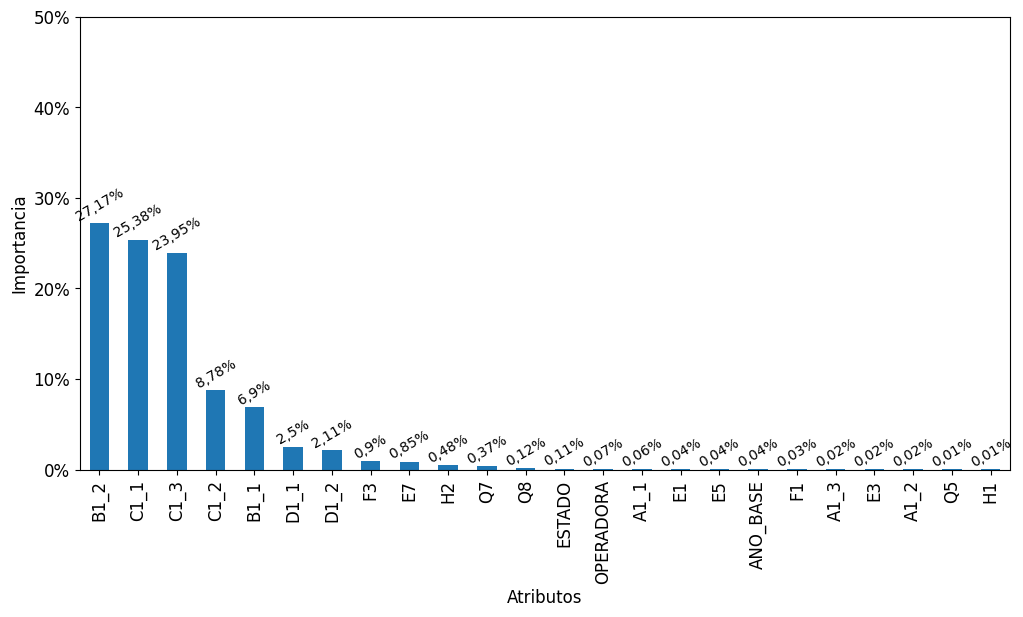

In [19]:
importances  = Models_Loaded_GridSearch["Gradient Boosting"].feature_importances_
forest_importances = pd.Series(importances, index=X_test.columns)
forest_importances_sorted = forest_importances.sort_values(ascending=False)

labels = list()
for i in forest_importances_sorted:
    i_str = str(round(i*100,2)) + "%"
    i_str = i_str.replace(".", ",")
    labels.append(i_str)


fig, ax = plt.subplots()
forest_importances_sorted.plot.bar()
ax.bar_label(ax.containers[0], labels=labels, rotation = 30)
plt.rcParams['axes.formatter.use_locale'] = True
ax.set_ylabel("Importancia", fontsize = 12)
ax.set_xlabel("Atributos", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim([0, 0.50])
plt.rcParams["figure.dpi"] = 100
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.gcf().set_size_inches(12, 6)

# SHAP

## Random Forest

In [7]:
### Aplicação em modo Desenvolvimento
#X_train, X_test, y_train, y_test = train_test_split(Dados_X, Dados_Y, test_size=0.5,random_state=109)

In [16]:
explainer = shap.TreeExplainer(Models_Loaded_GridSearch["RF"])
shap_values_RF = explainer.shap_values(X_test)

Insatisfeito


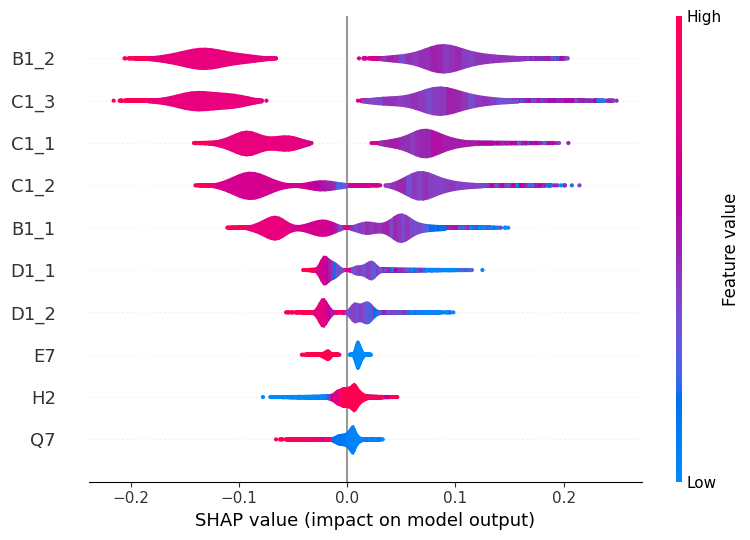

In [17]:
print("Insatisfeito")
shap.summary_plot(shap_values_RF[0], X_test, plot_type = 'violin', max_display = 10)

Satisfeito


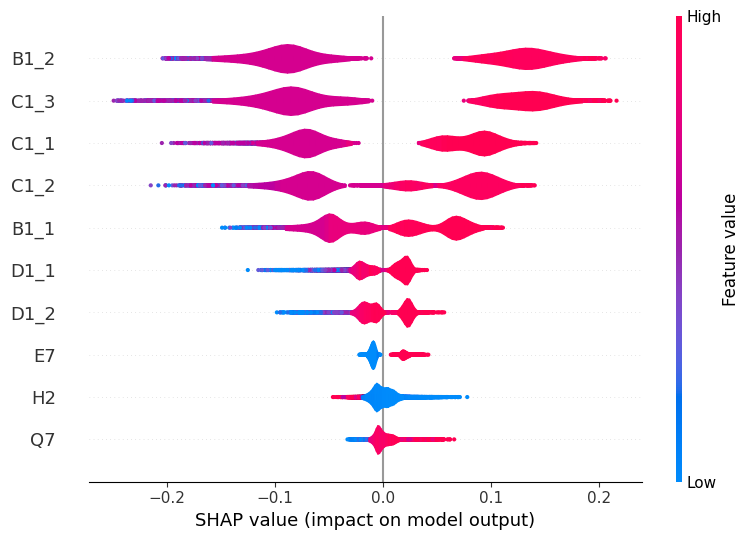

In [18]:
print("Satisfeito")
shap.summary_plot(shap_values_RF[1], X_test, plot_type = 'violin', max_display = 10)

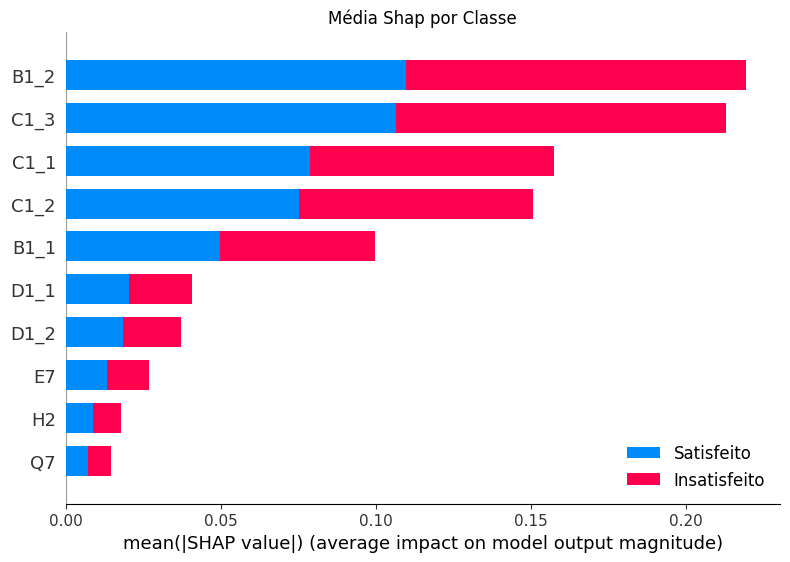

In [19]:
fig = plt.figure()
shap.summary_plot(shap_values_RF, X_test ,plot_type="bar", class_names = ["Insatisfeito", "Satisfeito"], max_display = 10, show = False)
plt.rcParams["figure.dpi"] = 100
plt.title("Média Shap por Classe") 
plt.show()


## Decision Tree

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["Decision Tree"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_DT = explainer(X_test)

## KNN

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["KNN"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_KNN = explainer(X_test)

## Ada Boost

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["Ada Boost"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_AB = explainer(X_test)

## Gradient Boosting

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["Gradient Boosting"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_GB = explainer(X_test)

## Histogram Gradient Boosting

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["Histogram Gradient Boosting"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_HGB = explainer(X_test)

## Logistic Regression

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["Logistic Regression"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_LR = explainer(X_test)

## Neural Network

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["Neural Network"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_NN = explainer(X_test)

## SVM

In [ ]:
explainer = shap.Explainer(Models_Loaded_GridSearch["SVM"].predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_SVM = explainer(X_test)